In [1]:
!pip install numba-cuda==0.4.0 numba==0.60 llvmlite==0.43

In [2]:
import numba.cuda

In [3]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [4]:
numba.cuda.detect()

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-79c5f6cb-1b9a-b7ab-dbad-20dc16fa1262
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [5]:
device = numba.cuda.select_device(0)
print("name:", device.name)

free_bytes, total_bytes = numba.cuda.current_context().get_memory_info()
print("total mem:", total_bytes)
print("free mem:", free_bytes)
print("multiprocessor count:", device.MULTIPROCESSOR_COUNT)
print("compute capability:", device.compute_capability)

# compute capability 7.5 has 64 cores per processor
core_count = device.MULTIPROCESSOR_COUNT * 64
print("core count:", core_count)

name: b'Tesla T4'
total mem: 15828320256
free mem: 15720382464
multiprocessor count: 40
compute capability: (7, 5)
core count: 2560


In [6]:
import numpy as np
from matplotlib import pyplot as plt
import urllib
from PIL import Image
import math
import time

(734, 1200, 3)


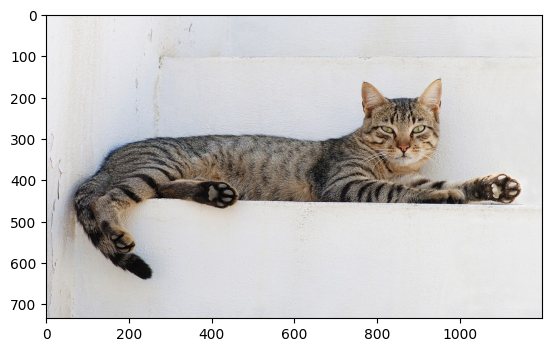

In [7]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Cat_August_2010-4.jpg/1200px-Cat_August_2010-4.jpg"
image = np.array(Image.open(urllib.request.urlopen(urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"}))))
plt.imshow(image)
print(image.shape)

In [8]:
@numba.cuda.jit
def bin_shared_src(src, dst):
  x, y = numba.cuda.grid(2)


  shared_src = numba.cuda.shared.array(shape=(16, 16), dtype=src.dtype)
  threadx = numba.cuda.threadIdx.x
  thready = numba.cuda.threadIdx.y

  block_top = numba.cuda.blockIdx.x * 16
  block_left = numba.cuda.blockIdx.y * 16

  for i in range(threadx, 16, 16):
    xi = block_top + i
    for j in range(thready, 16, 16):
      yj = block_left + j
      if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
        shared_src[i, j] = src[xi, yj]
  numba.cuda.syncthreads()

  if x < dst.shape[0] and y < dst.shape[1]:
    dst[x, y] = 1.0 if shared_src[threadx, thready] > 127 else 0.0


In [9]:
gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])

In [10]:
block_size = (16, 16)
grid_size = (math.ceil(gray.shape[0] / block_size[0]), math.ceil(gray.shape[1] / block_size[1]))

src = numba.cuda.to_device(gray)
dst = numba.cuda.device_array(gray.shape, gray.dtype)

bin_shared_src[grid_size, block_size](src, dst)

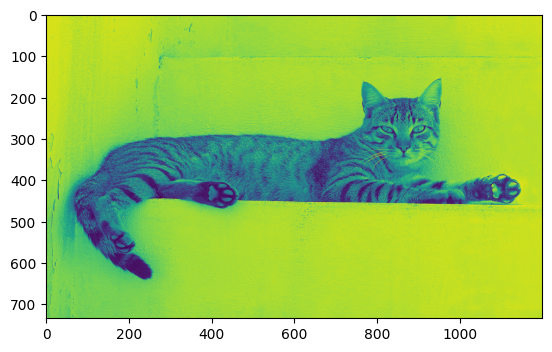

In [11]:
plt.imshow(gray)

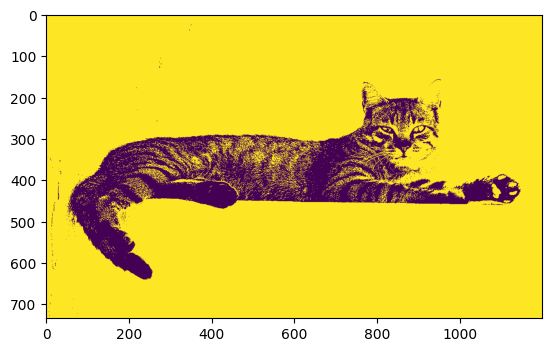

In [12]:
output = dst.copy_to_host()
plt.imshow(output)

In [13]:
@numba.cuda.jit
def brightness_shared_src(src, a, dst):
  x, y = numba.cuda.grid(2)


  shared_src = numba.cuda.shared.array(shape=(16, 16, 3), dtype=src.dtype)
  threadx = numba.cuda.threadIdx.x
  thready = numba.cuda.threadIdx.y

  block_top = numba.cuda.blockIdx.x * 16
  block_left = numba.cuda.blockIdx.y * 16

  for i in range(threadx, 16, 16):
    xi = block_top + i
    for j in range(thready, 16, 16):
      yj = block_left + j
      if (0 <= xi < src.shape[0]) and (0 <= yj < src.shape[1]):
        shared_src[i, j, 0] = src[xi, yj, 0]
        shared_src[i, j, 1] = src[xi, yj, 1]
        shared_src[i, j, 2] = src[xi, yj, 2]

  numba.cuda.syncthreads()

  if x < dst.shape[0] and y < dst.shape[1]:
    dst[x, y, 0] =  max(min(shared_src[threadx, thready, 0] + a, 255), 0)
    dst[x, y, 1] =  max(min(shared_src[threadx, thready, 1] + a, 255), 0)
    dst[x, y, 2] =  max(min(shared_src[threadx, thready, 2] + a, 255), 0)


In [14]:
block_size = (16, 16)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src = numba.cuda.to_device(image)
dst = numba.cuda.device_array(image.shape, image.dtype)

brightness = 20
brightness_shared_src[grid_size, block_size](src, brightness, dst)

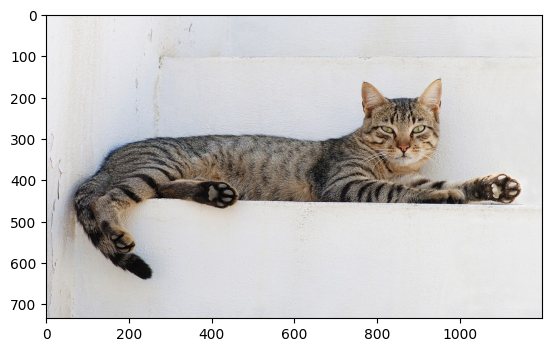

In [15]:
plt.imshow(image)

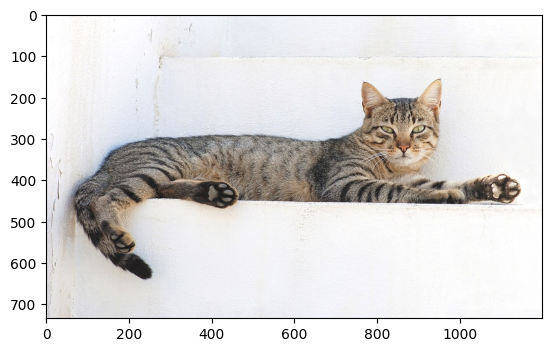

In [16]:
output = dst.copy_to_host()
plt.imshow(output)

In [40]:
@numba.cuda.jit
def mix_shared_src(src1, src2, a, dst):
  pass
  x, y = numba.cuda.grid(2)

  shared_src1 = numba.cuda.shared.array(shape=(16, 16, 3), dtype=numba.float32)
  shared_src2 = numba.cuda.shared.array(shape=(16, 16, 3), dtype=numba.float32)
  threadx = numba.cuda.threadIdx.x
  thready = numba.cuda.threadIdx.y

  block_top = numba.cuda.blockIdx.x * 16
  block_left = numba.cuda.blockIdx.y * 16

  for i in range(threadx, 16, 16):
    xi = block_top + i
    for j in range(thready, 16, 16):
      yj = block_left + j
      if (0 <= xi < src1.shape[0]) and (0 <= yj < src1.shape[1]):
        shared_src1[i, j, 0] = src1[xi, yj, 0]
        shared_src1[i, j, 1] = src1[xi, yj, 1]
        shared_src1[i, j, 2] = src1[xi, yj, 2]

        shared_src2[i, j, 0] = src2[xi, yj, 0]
        shared_src2[i, j, 1] = src2[xi, yj, 1]
        shared_src2[i, j, 2] = src2[xi, yj, 2]

  numba.cuda.syncthreads()

  if x < dst.shape[0] and y < dst.shape[1]:
    dst[x, y, 0] =  shared_src1[threadx, thready, 0] * a + shared_src2[threadx, thready, 0] * (1 - a)
    dst[x, y, 1] =  shared_src1[threadx, thready, 1] * a + shared_src2[threadx, thready, 1] * (1 - a)
    dst[x, y, 2] =  shared_src1[threadx, thready, 2] * a + shared_src2[threadx, thready, 2] * (1 - a)


In [33]:
random_image = np.random.randint(0, 255, size=image.shape, dtype=np.uint8)

In [48]:
block_size = (16, 16)
grid_size = (math.ceil(image.shape[0] / block_size[0]), math.ceil(image.shape[1] / block_size[1]))

src1 = numba.cuda.to_device(image)
src2 = numba.cuda.to_device(random_image)
dst = numba.cuda.device_array(image.shape, np.float32)

a = 0.7
mix_shared_src[grid_size, block_size](src1, src2, a, dst)

In [49]:
output = dst.copy_to_host()
output = output.astype(np.uint8)

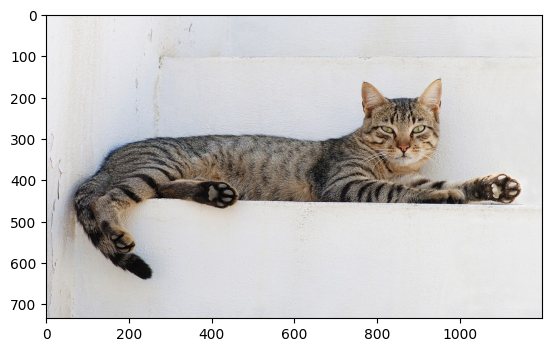

In [43]:
plt.imshow(image)

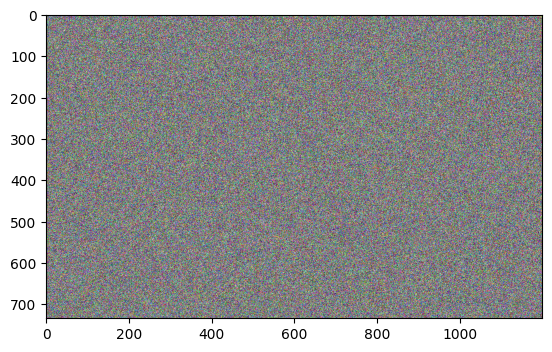

In [44]:
plt.imshow(random_image)

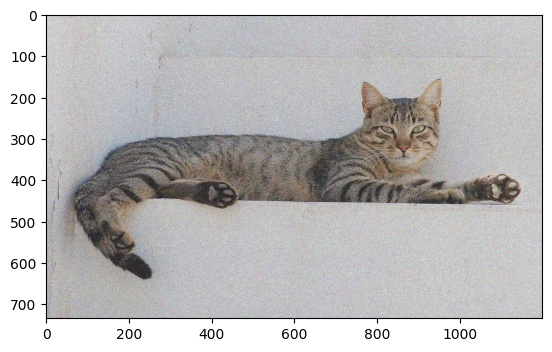

In [50]:
plt.imshow(output)